# Minimal

We demonstrate the gridding of fields with `cygrid` with a minimal example, using infrared data from the Planck mission. While the image here is only two-dimensional, we note that `cygrid` was designed for spectroscopic HI data, so the handling of the spectral axis is well-supported.

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`wcsaxes`](http://wcsaxes.readthedocs.org/en/latest/) needs to be available on your machine if you want to re-run the calculations. Furthermore, scipy is used to produce a comparison with cubic spline filtering. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from scipy.interpolate import griddata

import cygrid

Let's define some plotting `kwargs` for the images.

In [3]:
imkw = dict(origin='lower', interpolation='nearest')

For our first demonstration, we sample random data and add some point sources.

In [4]:
def setup_data(mapcenter, mapsize, beamsize_fwhm, num_samples, num_sources):
    '''
    Produce test data (including coords) - containing just noise and some point sources.
    
    Note: as in real astronomical measurements, the point sources are convolved with the
          instrument's response function (PSF), or telescope beam.
    '''

    lon_scale = np.cos(np.radians(mapcenter[1]))
    map_l, map_r = (
        mapcenter[0] - 1.1 * mapsize[0] / 2. / lon_scale,
        mapcenter[0] + 1.1 * mapsize[0] / 2. / lon_scale
        )
    map_b, map_t = mapcenter[1] - 1.1 * mapsize[1] / 2., mapcenter[1] + 1.1 * mapsize[1] / 2.
    
    # coordinates are drawn from a uniform distribution
    xcoords = np.random.uniform(map_l, map_r, num_samples).astype(np.float64)
    ycoords = np.random.uniform(map_b, map_t, num_samples).astype(np.float64)

    # add Gaussian noise
    signal = np.random.normal(0., 1., len(xcoords))
    
    beamsize_sigma = beamsize_fwhm / np.sqrt(8 * np.log(2))
    
    # put in artifical point source, with random amplitudes
    # we'll assume a Gaussian-shaped PSF
    
    def gauss2d(x, y, x0, y0, A, s):
        return A * np.exp(-((x-x0)**2 + (y-y0)**2) / 2. / s**2)
    
    for _ in range(num_sources):
        
        sou_x = np.random.uniform(map_l, map_r, 1).astype(np.float64)
        sou_y = np.random.uniform(map_b, map_t, 1).astype(np.float64)
        A = np.random.uniform(0, 10, 1)
        signal += gauss2d(xcoords, ycoords, sou_x, sou_y, A, beamsize_sigma)

    signal = signal[:, np.newaxis]  # need dummy spectral axis
    
    return xcoords, ycoords, signal

In [5]:
mapcenter = 60., 30.  # all in degrees
mapsize = 5., 5.
beamsize_fwhm = 0.1
num_samples = 10 ** 6
num_sources = 20

xcoords, ycoords, signal = setup_data(
    mapcenter, mapsize, beamsize_fwhm, num_samples, num_sources
    )

 Now define a FITS header dictionary, which we can feed to the gridder.

In [6]:
def setup_header(mapcenter, mapsize, beamsize_fwhm):
    '''
    Produce a FITS header that contains the target field.
    '''
    
    # define target grid (via fits header according to WCS convention)
    # a good pixel size is a third of the FWHM of the PSF (avoids aliasing)
    pixsize = beamsize_fwhm / 3.
    dnaxis1 = int(mapsize[0] / pixsize)
    dnaxis2 = int(mapsize[1] / pixsize)

    header = {
        'NAXIS': 3,
        'NAXIS1': dnaxis1,
        'NAXIS2': dnaxis2,
        'NAXIS3': 1,  # need dummy spectral axis
        'CTYPE1': 'RA---SIN',
        'CTYPE2': 'DEC--SIN',
        'CUNIT1': 'deg',
        'CUNIT2': 'deg',
        'CDELT1': -pixsize,
        'CDELT2': pixsize,
        'CRPIX1': dnaxis1 / 2.,
        'CRPIX2': dnaxis2 / 2.,
        'CRVAL1': mapcenter[0],
        'CRVAL2': mapcenter[1],
        }
    
    return header

In [7]:
target_header = setup_header(mapcenter, mapsize, beamsize_fwhm)

# let's already define a WCS object for later use in our plots:
target_wcs = WCS(target_header)

We start the gridding by initating the gridder with the `target_header`. Prior to this, we need to add a third axis to this header because `cygrid` was designed for three-dimensional data.

In [8]:
gridder = cygrid.WcsGrid(target_header)

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [9]:
kernelsize_fwhm = 2.5 / 60.  # degrees
# see https://en.wikipedia.org/wiki/Full_width_at_half_maximum
kernelsize_sigma = kernelsize_fwhm / np.log(8 * np.sqrt(2))
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates and the data. Note that we need to add an artifical third axis to the `input_data`.

In [10]:
gridder.grid(xcoords, ycoords, signal)

To get the gridded map, we simply call `get_datacube()`. We get rid of the degenerate third axis by using `squeeze()`.

In [11]:
cygrid_map = gridder.get_datacube().squeeze()

Now do the same with scipy's griddata function

In [12]:
def scipy_grid(xcoords, ycoords, signal, header, method='cubic'):
    '''
    Grid data using scipy.
    '''
    
    # first, we need to calculate the target world coordinates
    _wcs = WCS(header, naxis=[1, 2])
    _sh = header['NAXIS1'], header['NAXIS2']
    xpix, ypix = np.meshgrid(np.arange(_sh[0]), np.arange(_sh[1]))
    xwcs, ywcs = _wcs.celestial.all_pix2world(xpix, ypix, 0)
    
    return griddata(
        (xcoords, ycoords), signal, (xwcs, ywcs), method=method
        ).reshape(_sh)

In [13]:
scipy_map = scipy_grid(xcoords, ycoords, signal, target_header)

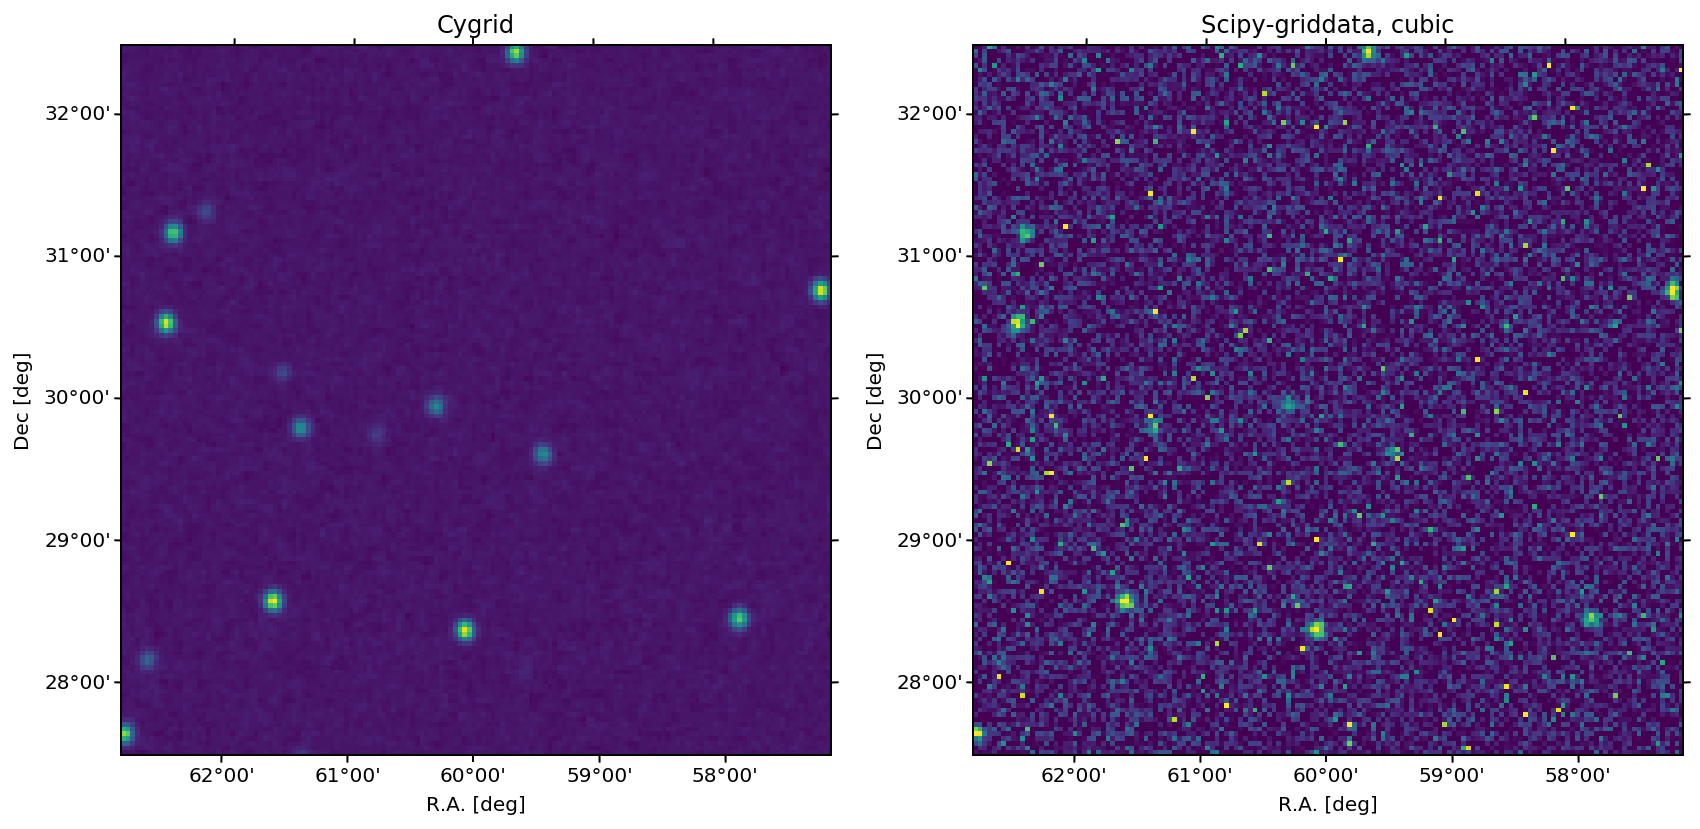

In [14]:
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121, projection=target_wcs.celestial)
ax2 = fig.add_subplot(122, projection=target_wcs.celestial)
ax1.imshow(cygrid_map, vmin=-0.5, vmax=8.0, **imkw)
ax2.imshow(scipy_map, vmin=-0.5, vmax=8.0, **imkw)
ax1.set_title('Cygrid')
ax2.set_title('Scipy-griddata, cubic')
for ax in ax1, ax2:
    lon, lat = ax.coords
    lon.set_axislabel('R.A. [deg]')
    lat.set_axislabel('Dec [deg]')

plt.show()

This shows a major drawback of the scipy griddata function - it is more of a interpolate function. Because only the nearest data points are considered, the noise is not going down as expected when the input data is oversampled. So, scipy-griddata is good for upsampling, but not downsampling of data.